In [32]:
!cat README.md

<a href="https://github.com/aloctavodia/BAP3>This book/repo</a>


In [35]:
#---------#---------#---------#---------#---------#---------#---------#---------
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

#np.random.seed(321)

### 2.1 Flipping Coins the PyMC Way

- θ ~ Beta(α=1, β=1)
- Υ ~ Binomial(n=1, p=θ)

In [2]:
trials = 4
theta_real = 0.35
data = pz.Binomial(n=1, p=theta_real).rvs(trials)

In [3]:
with pm.Model() as first_mod:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    idata = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


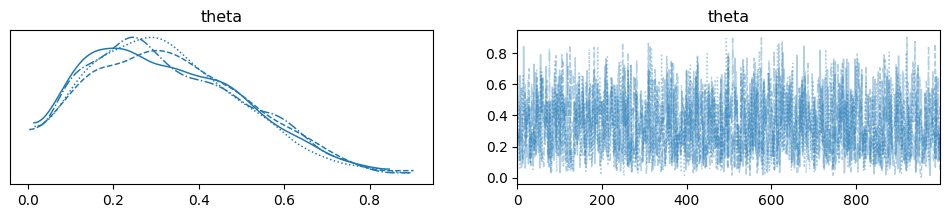

In [4]:
az.plot_trace(idata);

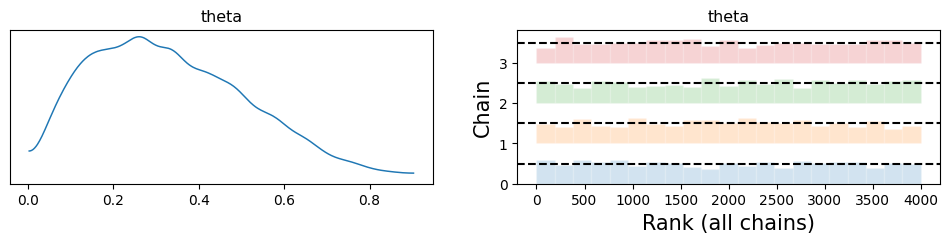

In [5]:
az.plot_trace(idata, kind='rank_bars', combined=True);

In [6]:
az.summary(idata, kind='stats').round(3)

,mean,sd,hdi_3%,hdi_97%
theta,0.332,0.18,0.033,0.651


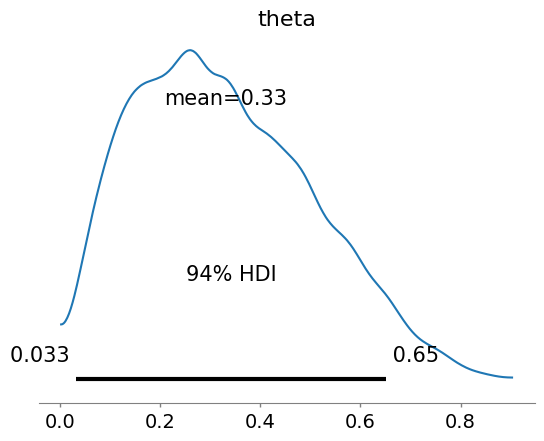

In [7]:
az.plot_posterior(idata);

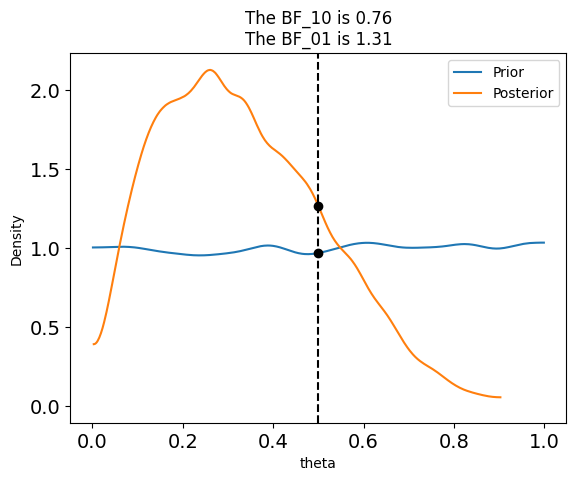

In [8]:
az.plot_bf(
    idata, var_name='theta', prior=np.random.uniform(0, 1, 10_000), ref_val=0.5);

Value of theta is 1.25 (BF_01)x more likely under posterior than prior.
BF_10: value of theta not being 0.5: 0.80x more likely under posterior than prior.

Rule of thumb: BF_01:
- 1 - 3.2: barely worth mentioning
- 3.2 - 10: substantial
- 10 - 100: strong
- 100+: decisive

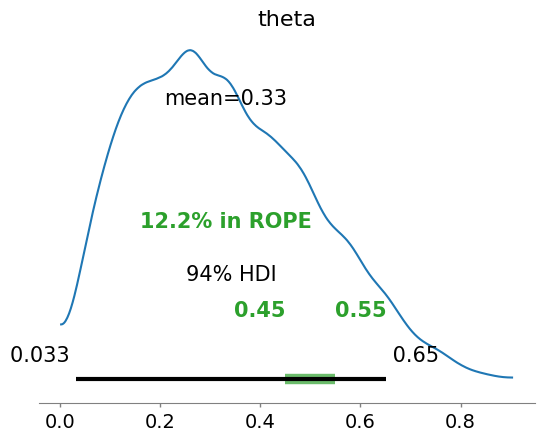

In [9]:
# ROPE: region of practical equivalence
az.plot_posterior(idata, rope=[0.45, 0.55]);

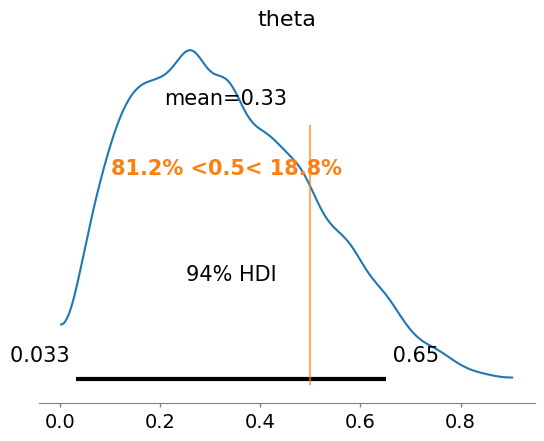

In [10]:
az.plot_posterior(idata, ref_val=0.5);

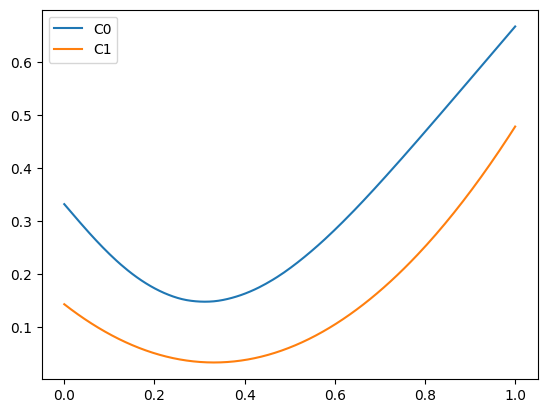

In [11]:
grid = np.linspace(0, 1, 200)
theta_pos = idata.posterior['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean(abs(i - theta_pos)**2) for i in grid]
for lossf, c in zip((lossf_a, lossf_b), ('C0', 'C1')):
    plt.plot(grid, lossf, label=c)
plt.legend();

In [12]:
np.mean(theta_pos), np.median(theta_pos)  # minima of above

(<xarray.DataArray 'theta' ()> Size: 8B
 array(0.33194669),
 np.float64(0.31166381437555396))

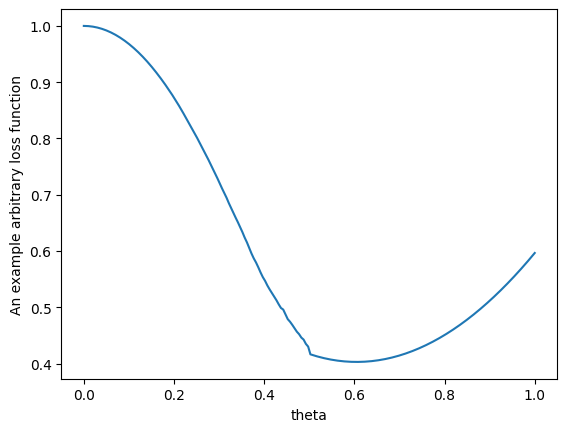

In [13]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1 / np.median(theta_pos / np.abs(i**2 - theta_pos))
    else:
        f = np.mean((i - theta_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)

plt.plot(grid, lossf)
plt.xlabel('theta')
plt.ylabel('An example arbitrary loss function');

In [14]:
with pm.Model() as mod_g:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sig = pm.HalfNormal('sigma', sigma=5)
    y = pm.Normal('y', mu=mu, sigma=sig, observed=data)
    idata_g = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


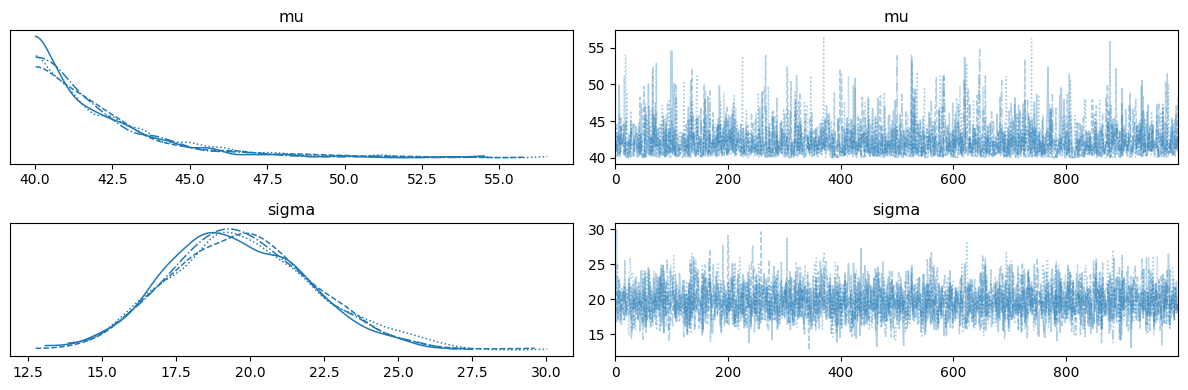

In [15]:
az.plot_trace(idata_g)
plt.tight_layout();

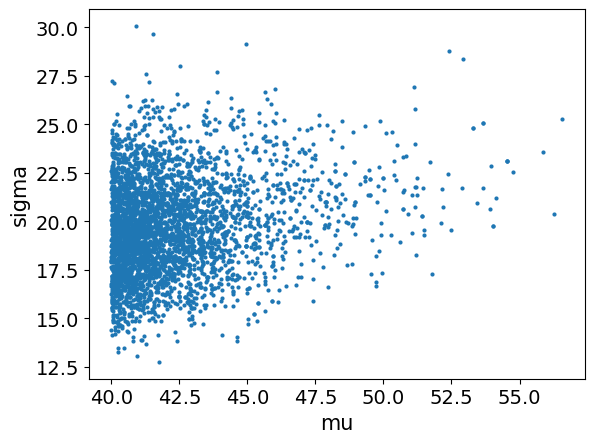

In [16]:
az.plot_pair(idata_g);

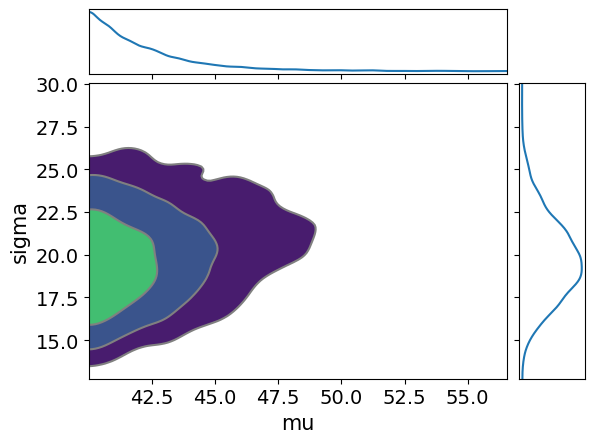

In [17]:
az.plot_pair(idata_g, kind='kde', marginals=True);

In [18]:
az.summary(idata_g, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
mu,42.25,2.3,40.00,46.37
sigma,19.72,2.4,15.34,24.22


In [19]:
pm.sample_posterior_predictive(idata_g, model=mod_g, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

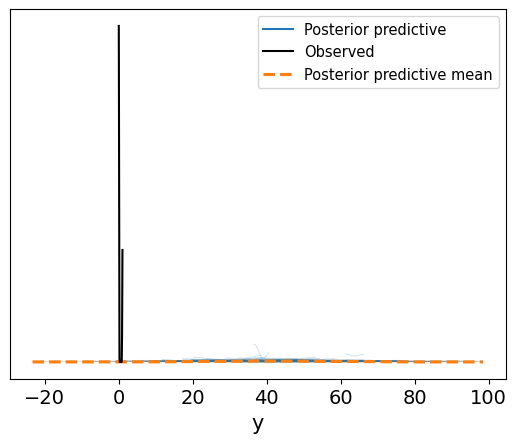

In [20]:
az.plot_ppc(idata_g, num_pp_samples=100);

In [21]:
with pm.Model() as mod_t:
    mu = pm.Uniform('mu', 40, 75)
    sig = pm.HalfNormal('sig', sigma=10)
    nu = pm.Exponential('nu', 1 / 30)
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sig, observed=data)
    idata_t = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sig, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


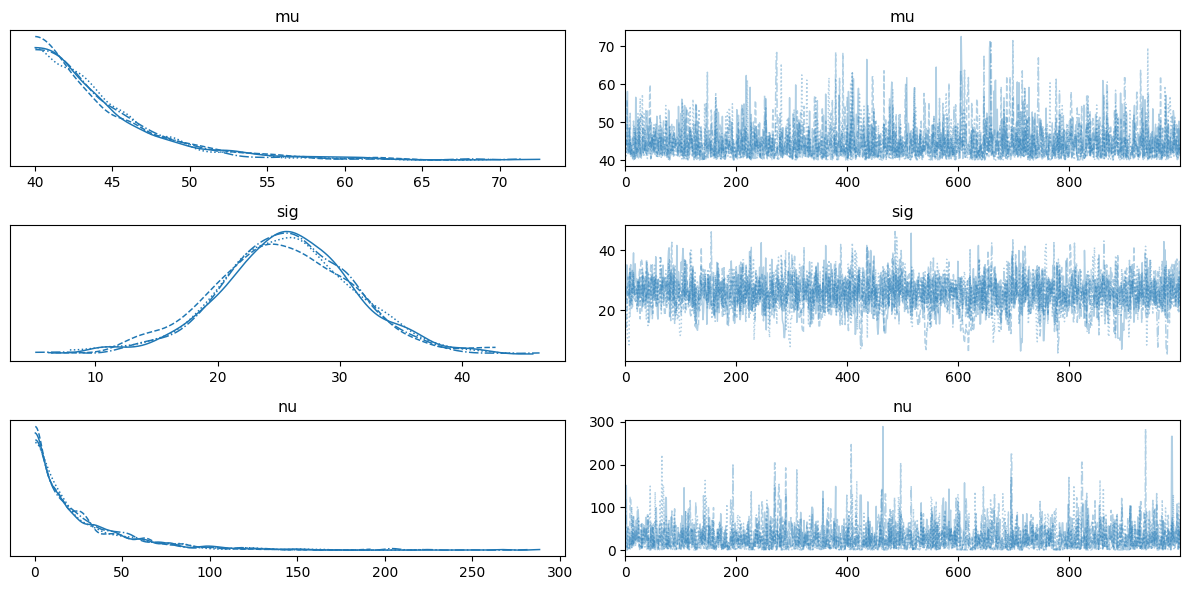

In [22]:
az.plot_trace(idata_t)
plt.tight_layout();

In [23]:
az.summary(idata_t, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
mu,44.49,4.40,40.00,52.40
sig,25.58,5.73,15.12,37.11
nu,27.12,30.57,0.17,80.64


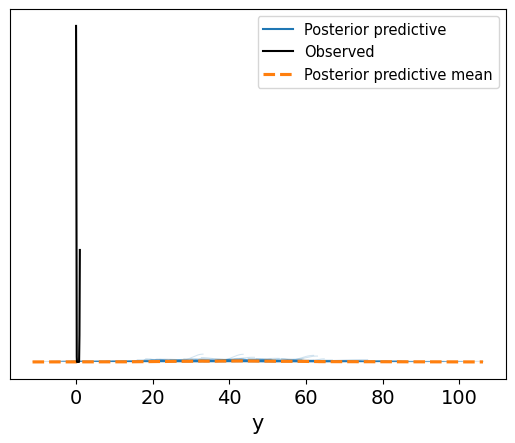

In [24]:
az.plot_ppc(idata_g, num_pp_samples=100);

In [25]:
posterior = idata_g.posterior
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset> Size: 56B
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 16B 0 2
    draw     int64 8B 0
Data variables:
    mu       (chain) float64 16B 42.11 40.66
    sigma    (chain) float64 16B 19.23 20.62
Attributes:
    created_at:                 2026-02-17T01:07:48.350712+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              0.5174210071563721
    tuning_steps:               1000

In [26]:
posterior.sel(draw=slice(0, 100))

<xarray.Dataset> Size: 7kB
Dimensions:  (chain: 4, draw: 101)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 808B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
Data variables:
    mu       (chain, draw) float64 3kB 42.11 42.11 41.15 ... 43.9 40.77 45.05
    sigma    (chain, draw) float64 3kB 19.23 19.23 19.87 ... 19.02 19.18 19.8
Attributes:
    created_at:                 2026-02-17T01:07:48.350712+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              0.5174210071563721
    tuning_steps:               1000

In [27]:
posterior.mean()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 42.25
    sigma    float64 8B 19.72
Attributes:
    created_at:                 2026-02-17T01:07:48.350712+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              0.5174210071563721
    tuning_steps:               1000

In [28]:
posterior.mean('draw')

<xarray.Dataset> Size: 96B
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
Data variables:
    mu       (chain) float64 32B 42.09 42.45 42.37 42.08
    sigma    (chain) float64 32B 19.53 19.85 19.8 19.69
Attributes:
    created_at:                 2026-02-17T01:07:48.350712+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              0.5174210071563721
    tuning_steps:               1000

In [29]:
stacked = az.extract(idata_g)
az.extract(idata_g, num_samples=100)

<xarray.Dataset> Size: 4kB
Dimensions:  (sample: 100)
Coordinates:
  * sample   (sample) object 800B MultiIndex
  * chain    (sample) int64 800B 2 3 0 2 3 3 1 0 3 3 2 ... 2 3 3 3 1 2 3 3 3 1 3
  * draw     (sample) int64 800B 336 962 936 157 73 461 ... 156 373 485 230 993
Data variables:
    mu       (sample) float64 800B 42.3 41.69 42.46 40.11 ... 45.74 41.07 42.87
    sigma    (sample) float64 800B 20.57 21.27 18.77 19.68 ... 19.23 17.29 19.05
Attributes:
    created_at:                 2026-02-17T01:07:48.350712+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              0.5174210071563721
    tuning_steps:               1000

In [36]:
tips = pd.read_csv(
    'https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/'
    'data/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [37]:
categories = np.array(['Thur', 'Fri', 'Sat', 'Sun'])
tip = tips.tip.values
idx = pd.Categorical(tips.day, categories=categories).codes

In [38]:
with pm.Model() as comparing_groups:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=4)
    sig = pm.HalfNormal('sig', sigma=10, shape=4)
    y = pm.Normal('y', mu=mu[idx], sigma=sig[idx], observed=tip)